# Task 2
We are provided with 100 images, accompanied with a csv file containing information about each object in the image. Each image has a varying number of objects, and hence their are a varying number of vectors (csv rows) representing each image. In other words, each image is represented by a varying number of feature vectors. 

A common approach to fact that each image is represented with a different number of feature vectors is to use Bag of Words (BoW). This method is commonly used to find similar images in a dataset (known as Visual Bag of Words - VBoW). The method is as follows:
1. The entire dataset is our corpus. We cluster the corpus into k clusters, and each cluster is represented by a centroid.
2. Each feature vector in the dataset is assigned to the cluster with the closest centroid. 
3. Each image is represented by a histogram of the number of feature vectors in each cluster. The histogram is normalized, and each word is weighted by its inverse appearance frequency (also known as inverse document frequency - IDF).
4. This histogram is the BoW representation of the image.

After each image will be represented by its words histogram, we will train an autoencoder to learn the representation of the image. The autoencoder will be trained on the words histogram. After training, the latent space will be used to classify the images using K-Means with cosine similarity.

## Data Preprocessing - Building BoW
Parameters:
- `k`: The number of words to cluster the corpus into. We will use 32, as we want a sparse representation, but not too sparse.

In [10]:
# PARAMETERS
K = 64  # number words in BoW representation
LATENT_DIM = 3  # number of autoencoder latent dimensions
EPOCHS = 1000   # number of training epochs
BATCH_SIZE = 2 # number of training samples per batch

In [11]:
import sklearn
import numpy as np
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib widget

# read the corpus
# ---------------
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)

data = data[1:] # remove header

# give each image a unique id
# ---------------------------
data = np.array(data)
image_ids = np.unique(data[:,0])
image_id_to_index = {image_id: i for i, image_id in enumerate(image_ids)}

# Create a codebook with K words
features = np.array(data[:, 2:], np.float32) # raw features (without image id and label)
kmeans = KMeans(n_clusters=K, random_state=0).fit(features)

# convert every feature vector to a word:
words = kmeans.predict(features)

# calculate the tf-idf weights
# ----------------------------
# calculate the frequency of each word
word_freq = np.zeros(K)
for word in words:
    word_freq[word] += 1

# calculate the number of images containing each word (on log scale)
idf = np.log(len(image_ids) / 1 + word_freq)

# calculate the tf-idf weights
images_BoW = np.zeros((len(image_ids), K))
for image_id, word in zip(data[:,0], words):
    images_BoW[image_id_to_index[image_id], word] += 1
images_BoW *= idf

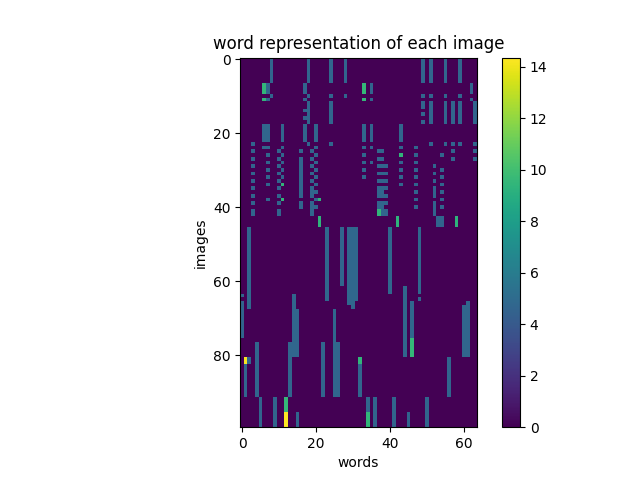

In [12]:
# reprsenting the histogram of words for each image
# -------------------------------------------------
plt.figure()
plt.imshow(images_BoW)
plt.xlabel('words')
plt.ylabel('images')
plt.title('word representation of each image')
cbar = plt.colorbar()
plt.show()





## Autoencoder
We now have our dataset represented as a bag of words. Each image is represented by a histogram of the appearance of each word in the image. Each word is weighted by its importance in the corpus (tf-idf). We will now train an autoencoder to learn the representation of the image in the latent space. 

<img src="images/autoencoder.webp" width="400"/>

The autoencoder will be based on the fully connected layers. The latent space will be of size 3

In [13]:
import torch
import torch.nn as nn

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),            
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim),                
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),

        )
    
        # # initialize the weights
        # self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.5)

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        
        # Decode the encoded input
        decoded = self.decoder(encoded)
        
        return encoded, decoded

# Create an instance of the autoencoder
input_dim = K  # Input dimension
latent_dim = LATENT_DIM  # Latent dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)
# Print the autoencoder architecture
print(autoencoder)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=64, bias=True)
  )
)


## Training the Autoencoder


model saved
Epoch [1/1000], Loss: 4.9128
model saved
Epoch [2/1000], Loss: 2.5777
Epoch [3/1000], Loss: 3.4798
Epoch [4/1000], Loss: 4.1578
model saved
Epoch [5/1000], Loss: 2.1559
Epoch [6/1000], Loss: 3.4575
model saved
Epoch [7/1000], Loss: 1.3172
Epoch [8/1000], Loss: 2.2073
Epoch [9/1000], Loss: 1.8498
Epoch [10/1000], Loss: 1.5749
Epoch [11/1000], Loss: 1.9432
model saved
Epoch [12/1000], Loss: 0.9035
model saved
Epoch [13/1000], Loss: 0.0873
Epoch [14/1000], Loss: 0.2292
Epoch [15/1000], Loss: 0.8542
Epoch [16/1000], Loss: 0.2729
Epoch [17/1000], Loss: 0.2088
Epoch [18/1000], Loss: 0.3647
Epoch [19/1000], Loss: 0.7738
Epoch [20/1000], Loss: 0.3842
Epoch [21/1000], Loss: 0.4455
Epoch [22/1000], Loss: 0.2566
Epoch [23/1000], Loss: 0.8605
Epoch [24/1000], Loss: 0.3804
Epoch [25/1000], Loss: 1.3453
Epoch [26/1000], Loss: 0.1569
model saved
Epoch [27/1000], Loss: 0.0211
Epoch [28/1000], Loss: 0.2759
Epoch [29/1000], Loss: 0.8084
Epoch [30/1000], Loss: 0.0885
Epoch [31/1000], Loss: 0.

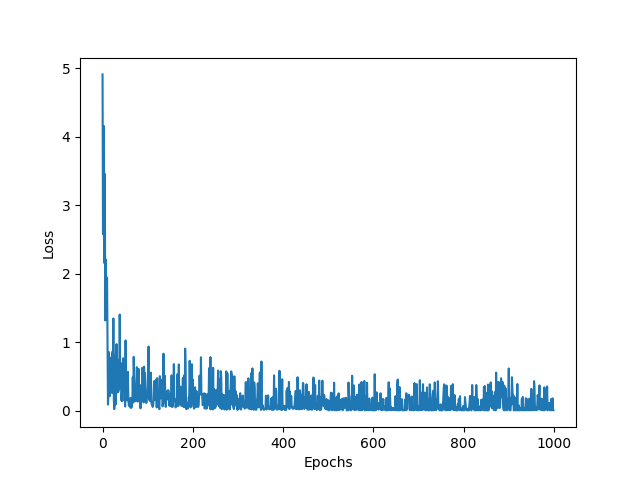

best epoch: 651, best loss: 0.0019204930867999792


In [14]:
import torch.optim as optim

autoencoder = Autoencoder(input_dim, LATENT_DIM)
autoencoder.to(device)

images_BoW_tensor = torch.from_numpy(images_BoW).to(device)
images_BoW_tensor = images_BoW_tensor.type(torch.FloatTensor)
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1E-3) #1E-4
# add a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

# Train the autoencoder
num_epochs = EPOCHS
batch_size = BATCH_SIZE

loss_recorder= []
min_loss = 1000000
for epoch in range(num_epochs):
    # Shuffle the data
    indices = torch.randperm(images_BoW_tensor.size(0))
    shuffled_images_BoW = images_BoW_tensor[indices]
    
    # Split the data into batches
    num_batches = len(shuffled_images_BoW) // batch_size
    for i in range(num_batches):
        # Get a batch of data
        batch = shuffled_images_BoW[i * batch_size: (i + 1) * batch_size]
        
        # Move the batch to CUDA if available
        batch = batch.to(device)
        
        
        # Forward pass
        _, output = autoencoder(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save best weights
    if loss.item() < min_loss:
        min_loss = loss.item()
        torch.save(autoencoder.state_dict(), 'best_model_task2.pth')
        print('model saved')
        best_epoch = epoch    
    # Decay the learning rate
    scheduler.step()

    # add loss
    loss_recorder.append(loss.item())
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")#, Learning rate: {scheduler.get_lr()[0]:.8f}")

# Plot the loss
plt.figure()
plt.plot(loss_recorder)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f"best epoch: {best_epoch}, best loss: {min_loss}" )


## Run K-Means on the Latent Space
Now, lets pass the BoW representing each image and get the latent space representation. 
Finding the optimal K values is crucial for the performance of K-Means. We will use the elbow method to find the optimal K value. The elbow method is as follows:
1. Run K-Means for a range of K values (1-10)
2. For each K value, calculate the sum of squared errors (SSE) of points relative to cluster centroid.
3. Plot the SSE for each K value
4. The optimal K value is the K value where the SSE starts to flatten out (the elbow)


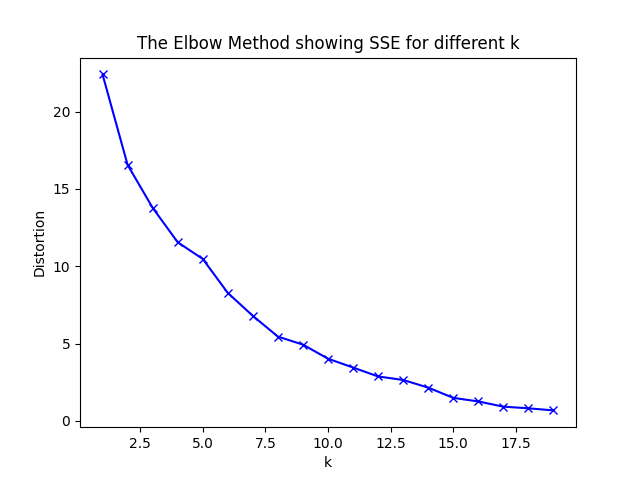

In [15]:
from scipy.spatial.distance import cdist

# Load the best model
autoencoder.load_state_dict(torch.load('best_model_task2.pth'))
autoencoder.to(device)
# use for inference
autoencoder.eval()

# Encode the data
encoded_data, _ = autoencoder(images_BoW_tensor.to(device))
encoded_data = encoded_data.detach().cpu().numpy()

# calculate optimal number of clusters with the elbow method
# ---------------------------------------------------------
# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(encoded_data)
    kmeanModel.fit(encoded_data)
    distortions.append(sum(np.min(cdist(encoded_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / encoded_data.shape[0])

# Plot the elbow
plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing SSE for different k')
plt.show()

## Run K-Means on the Latent Space
The elbow method suggests the optimal K=7 (where the SSE starts to flatten out).
Now we will run K-Means to cluster the latent space.


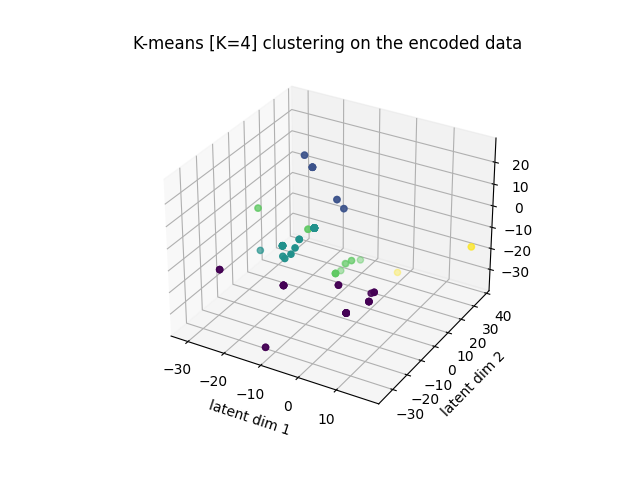

In [16]:
# Run k-means on the encoded data
kmeans = KMeans(n_clusters=5, random_state=0).fit(encoded_data)

# Plot the encoded data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_data[:,0], encoded_data[:,1], encoded_data[:,2], c=kmeans.labels_, marker='o')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title('K-means [K=4] clustering on the encoded data')
plt.show()

### Store the images according to their clusters
Each image will be stored under `/task_2/cluster_i` where i is the cluster number the image belongs to.

In [17]:
import os
import shutil
os.makedirs('task_2', exist_ok=True)

image_idx_to_name = {v: k for k, v in image_id_to_index.items()}
data_path = "/DATA/Autobrains/EON/Images/"
# find the cluster of each image and copy it to a folder
for image_id, cluster in enumerate(kmeans.labels_):
    cluster = int(cluster)   
    image_path = str(image_idx_to_name[image_id]) + ".png"
    if os.path.exists(data_path + image_path):
        os.makedirs(f'task_2/{cluster}', exist_ok=True)
        shutil.copy(data_path + image_path, f'task_2/{cluster}/'+image_path)

    else: 
        print(f'Image {data_path + image_path} not found')
        
        

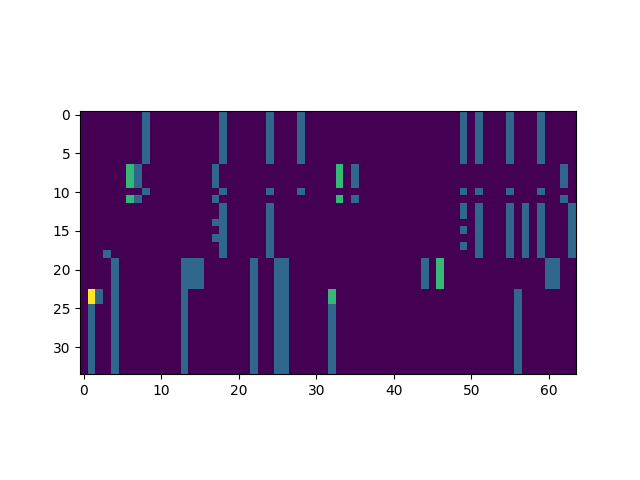

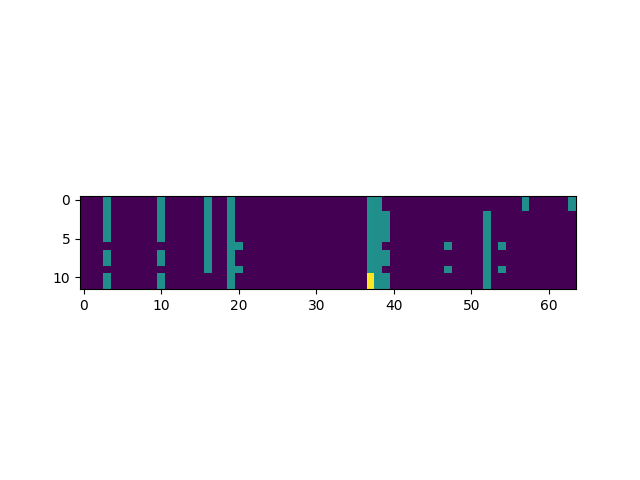

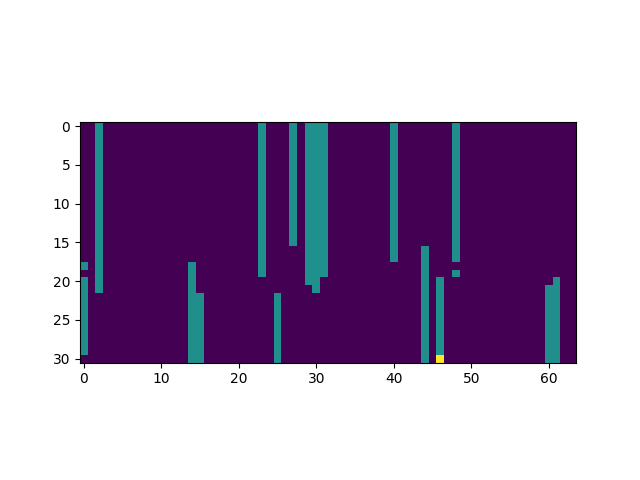

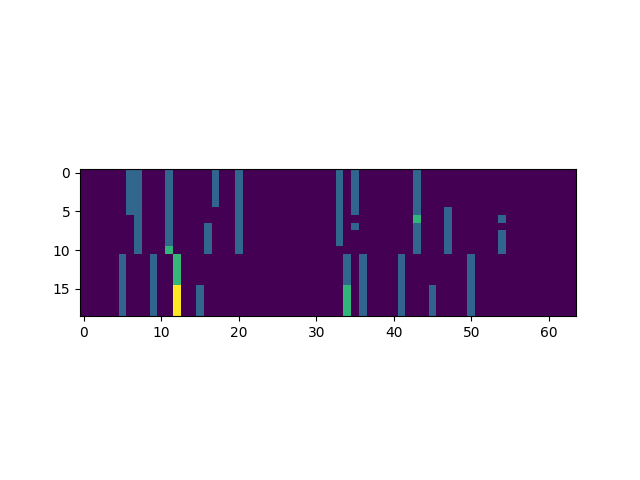

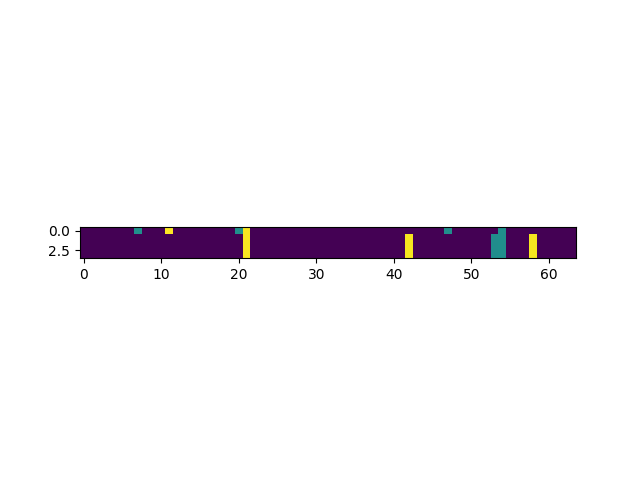

In [18]:
# plot the histograms of the words in each cluster
# ------------------------------------------------

# find the images in each cluster
images_in_cluster = []
n_clusters = len(np.unique(kmeans.labels_))
# find indices of images in each cluster
for cluster in range(n_clusters):
    images_in_cluster.append(np.where(kmeans.labels_ == cluster)[0])
    plt.figure()
    # imshow bag of words
    plt.imshow(images_BoW[images_in_cluster[cluster], :])
    plt.show()
